<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/developtemp/Vader_lexicon_12K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lexicon(감성 어휘 사전) 기반 감성 분류: traning data의 레이블을 학습하는 것이 아닌 특정 감정을 나타내는 감성 어휘 사전을 학습. 레이블링이 안 되어있는 데이터에 대해 사전에 있는 어휘와 매칭시킨다. 비지도 학습에 많이 사용된다.

**>>"IMDB Dataset"은 레이블을 포함하고 있기 때문에
lexicon 기반 sentiment열만 분류시킨 결과와,
원래 레이블과 정확도를 비교 해볼 것.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/ML/TP/12K IMDB Dataset.csv'

Mounted at /content/drive


## <데이터 확인>

In [3]:
import pandas as pd
df = pd.read_csv(path)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive
...,...,...
11995,If there's one thing you can count on Disney t...,negative
11996,I wouldn't rent this one even on dollar rental...,negative
11997,Is there anything else on earth to be more ent...,negative
11998,There was a time when Joel Schumacher was rank...,negative


## <데이터 전처리>
1. HTML 태그와 같은 마크다운 문법과 연관된 태그는 모두 제거
2. 특수문자 제거
3. Non-Ascii 문자 액센트(불어 등)가 붙어있어 있는 단어를 어휘 사전에서 매칭이  가능한 형태로 변환 ###생략함
4. 축약된 단어 풀기; don't → do not, I'd → I would 혹은 I could
5. 어간 추출(stemming: arguing->argu) 혹은 표제어 추출(lemmatization: flies->fly)
6. 불용어 제거(stopwords): 조사, 관사 등 자주 출현하나 전체적인 의미에 큰 영향을 주지 않는 단어 제거

In [4]:
pip install html5lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 1.3 MB/s eta 0:00:00


In [5]:
pip install BeautifulSoup4

In [6]:
from bs4 import BeautifulSoup
import re #정규표현식
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')

review=df['review']

#축약단어 푸는 함수
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


#어근 추출하는 함수(스테머)
#stemmer=nltk.stem.PorterStemmer()
#표제어 추출하는 함수(레머타이저)
#lemmatizer = WordNetLemmatizer()
'''
문장 200자 길이로 제한하고
stemmer만 했을 때: 0.64383
lemmertizer만 했을 때: 0.644
둘 다 안 했을 때: 0.66891
'''
def clean(review):
  review_text=BeautifulSoup(review, 'html5lib').get_text() # HTML 태그 제거
  review_text=re.sub('[^a-zA-Z]', ' ', review_text) # 영어 문자 제외 나머지 기호(쉼표, 느낌표, 숫자 등) 제거하고 공백으로 대체
  review_text=decontraction(review_text) # 축약단어 풀기
  review_text=review_text.lower() # 소문자 변환

  review_words=review_text.split() # 단어로 분해 시킨 뒤에
  #review_words=[stemmer.stem(word) for word in review_words] # 어근 추출
  #review_words=[lemmatizer.lemmatize(word) for word in review_words] # 표제어 추출

  stop_words = set(stopwords.words('english'))
  review_words=[w for w in review_words if w not in stop_words] # 불용어 제거

  review_text=' '.join(review_words)
  clean_review=review_text
  return clean_review

df['review']=review.apply(clean)
review

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-6-5825cd4973de>:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text=BeautifulSoup(review, 'html5lib').get_text() # HTML 태그 제거


0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Petter Mattei's "Love in the Time of Money" is...
4        Probably my all-time favorite movie, a story o...
                               ...                        
11995    If there's one thing you can count on Disney t...
11996    I wouldn't rent this one even on dollar rental...
11997    Is there anything else on earth to be more ent...
11998    There was a time when Joel Schumacher was rank...
11999    Oh, man, I hated this movie. Granted, the site...
Name: review, Length: 12000, dtype: object

레이블 0, 1로 인코딩

In [7]:
#정확도 비교를 쉽게 하기 위해 positive를 1, negative를 0으로 매핑
sentiment_mapping = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].replace(sentiment_mapping)
df

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,petter mattei love time money visually stunnin...,1
4,probably time favorite movie story selflessnes...,1
...,...,...
11995,one thing count disney uncanny ability take st...,0
11996,rent one even dollar rental night,0
11997,anything else earth enticing learn expects fra...,0
11998,time joel schumacher ranked quite high list fa...,0


## 리뷰 한 문장 당 단어 수 제한하기 (제한 안 하는 게=600개 단어로 제한해서 빠지는 단어 없게 하는 게 accuracy=0.671, area=0.671로 더 높았음)

In [8]:
# 단어로 분리시키기, 배열로 생성됨
review_words = [sentence.split(' ') for sentence in df['review']]

# 분리 샘플 5개 보기
for i in range(5):
    print(review_words[i])

['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget', 'charm', 'for

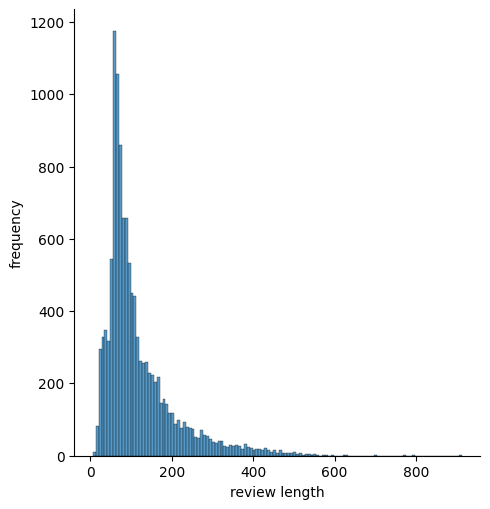

In [9]:
# review 문장 길이(문장 별 단어 수) 통계
import seaborn as sns
import matplotlib.pyplot as plt

review_len = [len(sentence) for sentence in review_words]
review_len.sort()
sns.displot(review_len)
plt.xlabel('review length')
plt.ylabel('frequency')
plt.show()

In [10]:
#타입 확인
print(type(df['review'])) #pandas series
print(type(review_words)) #list

<class 'pandas.core.series.Series'>
<class 'list'>


In [11]:
# 각 문장의 단어 개수를 600개까지로만 제한
review_words_mini = []

for sentence in review_words:
  review_words_mini.append([word for word in sentence][:600])

for i in range(5):
    print(review_words_mini[i])

['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget', 'charm', 'for

In [12]:
#타입 재확인
print(type(df['review'])) #pandas series
print(type(review_words)) #list
print(type(review_words_mini)) #list

<class 'pandas.core.series.Series'>
<class 'list'>
<class 'list'>


In [13]:
#review_words_mini를 array로 변환시키기
import numpy as np

review_strings = [' '.join(sublist) for sublist in review_words_mini]
review_words_mini_arr = np.array(review_strings)

#샘플 출력
print(review_words_mini_arr[:5])

['one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skil

## **Vader lexicon**

In [14]:
! pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.5 MB/s eta 0:00:00


In [15]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [16]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

#pos 점수가 neg점수보다 큰 경우에는 1 반환하는 함수
def vader_polarity(text):
    score = analyzer.polarity_scores(text)
    return 1 if score['pos'] > score['neg'] else 0

#샘플 5개 출력
for review in review_words_mini_arr[:5]:
    print('Text:', review)
    print('Predicted Sentiment polarity:', analyzer.polarity_scores(review))
    print('Predicted Sentiment polarity Class:', vader_polarity(review))
print('-'*60)
for index, row in df.loc[0:4, :].iterrows():
    print('Real Sentiment:', row['sentiment'])

Text: one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street 

In [17]:
from sklearn.metrics import accuracy_score

#실제 감정분류 리스트(원래 data에 있던 sentiment열 데이터)
actual_sentiments = []
for index, row in df.iterrows():
    actual_sentiments.append(row['sentiment'])

#추측한 감정분류 리스트(원래 data의 review열과 감성어휘분석을 통해 추측한 sentiment들)
predicted_sentiments = []
for review in review_words_mini_arr:
    predicted_sentiment = vader_polarity(review)
    predicted_sentiments.append(predicted_sentiment)

#ACCURACY만 일단 출력
accuracy = accuracy_score(actual_sentiments, predicted_sentiments)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6708333333333333


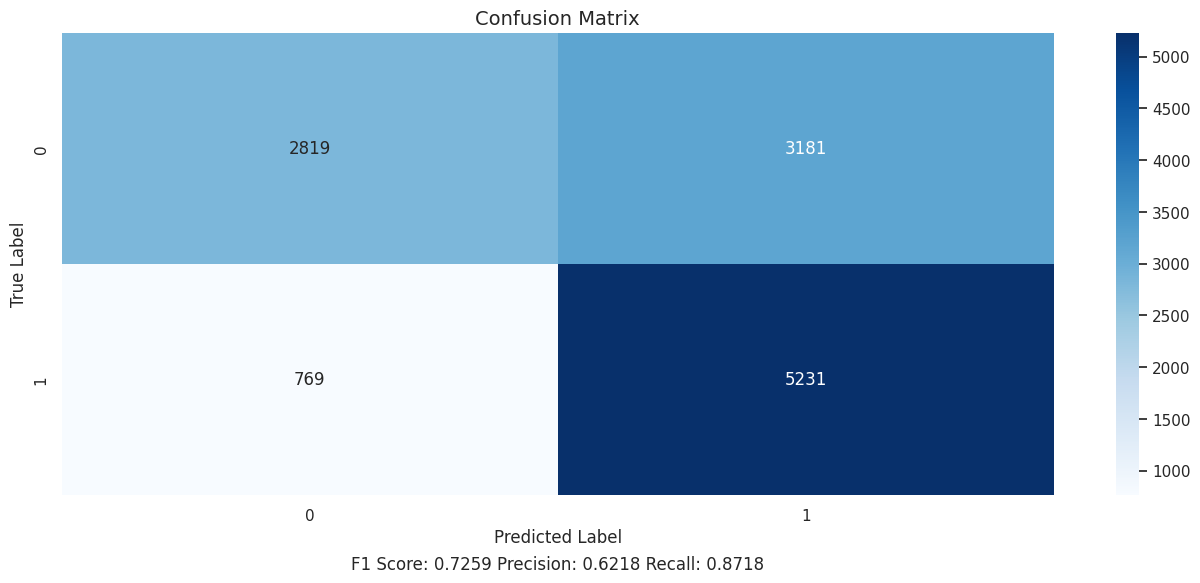

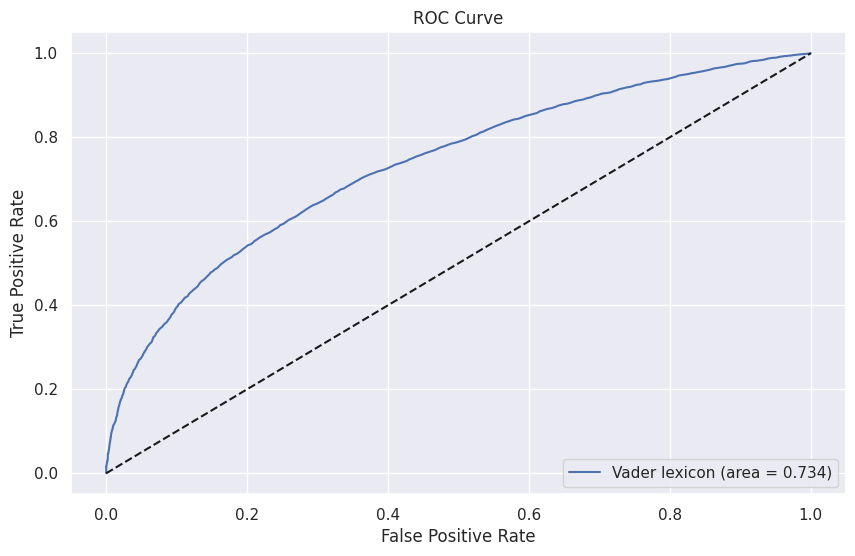

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#평가 척도 계산
cm = confusion_matrix(actual_sentiments, predicted_sentiments)
f1 = f1_score(actual_sentiments, predicted_sentiments)
precision = precision_score(actual_sentiments, predicted_sentiments)
recall = recall_score(actual_sentiments, predicted_sentiments)

#시각화
fig, axes = plt.subplots(figsize=(16, 6))

#시각화1-confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axes)
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1:.4f} Precision: {precision:.4f} Recall: {recall:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,fontsize=12)
plt.show()

#ROC curve를 곡선으로 그리기 위해 이진값이 아닌 확률 사용
#확률 반환하는 함수
def vader_polarity_prob(text):
    score = analyzer.polarity_scores(text)
    return score['pos']

predicted_probabilities = []
for review in review_words_mini_arr:
    predicted_prob = vader_polarity_prob(review)
    predicted_probabilities.append(predicted_prob)

#시각화2-ROC curve
fp, tp,_ = roc_curve(actual_sentiments, predicted_probabilities)#roc curve를 계산
auroc_baseline = roc_auc_score(actual_sentiments, predicted_probabilities)#auroc를 계산
plt.figure(figsize=(10, 6))
plt.plot(fp, tp, label=f'Vader lexicon (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## **TextBlob lexicon(practice)**
: 단어제한 아예 반영 안함.

In [19]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 4.0 MB/s eta 0:00:00


In [20]:
#감정 분석 5개 미리보기
from textblob import TextBlob
for index, row in df.loc[0:4, :].iterrows(): #5개 행에 대해서만 샘플로 보여주기
    review = row['review']
    print(f'review {index} : {review.strip()}')
    print('sentiment:', row['sentiment'])
    print('Predicted sentiment polarity:', TextBlob(review).sentiment.polarity) #sentiment의 polarity(극성)는 -1.0은 매우 부정적인 감정, 1.0은 매우 긍정적인 감정을 의미
    print('-'*60)

review 0 : one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack st

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#실제 감정분류 리스트(원래 data에 있던 sentiment열 데이터)
actual_sentiments = []

#추측한 감정분류 리스트(원래 data의 review열과 감성어휘분석을 통해 추측한 sentiment들)
predicted_sentiments = []
for index, row in df.iterrows():
    review = row['review']
    polarity = TextBlob(review).sentiment.polarity
    predicted_sentiment = 1 if polarity > 0 else 0 #sentiment polarity 값이 0 초과면 긍정으로 분류시키도록 함(긍정, 부정 이진 분류만 하면 되므로)
    actual_sentiments.append(row['sentiment'])
    predicted_sentiments.append(predicted_sentiment)

#ACCURACY만 일단 출력
accuracy = accuracy_score(actual_sentiments, predicted_sentiments)
print(f'Accuracy: {accuracy}')


Accuracy: 0.70325


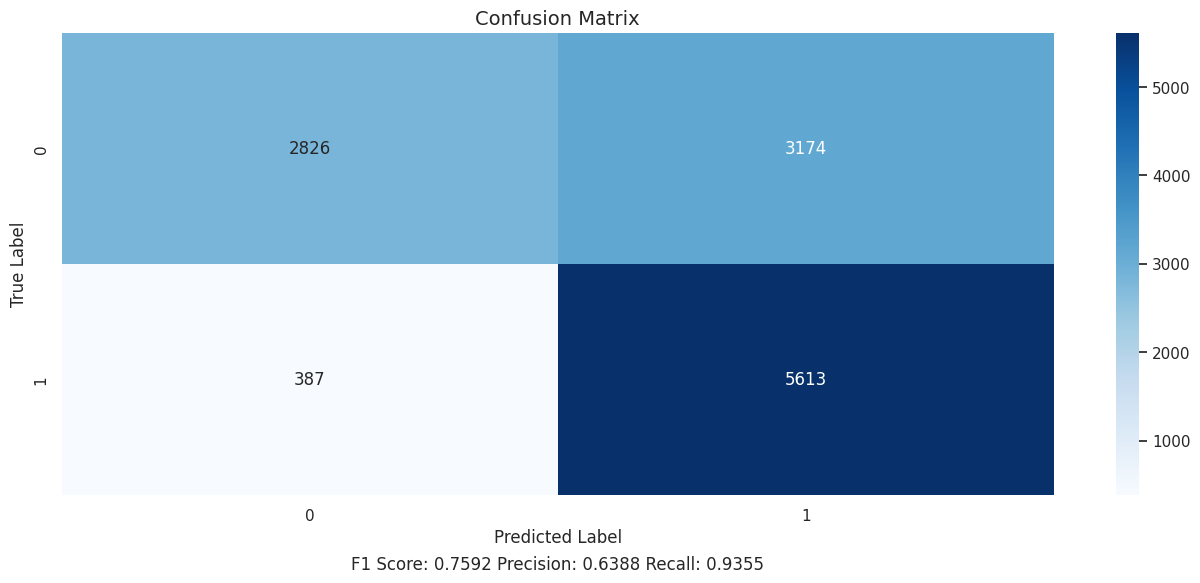

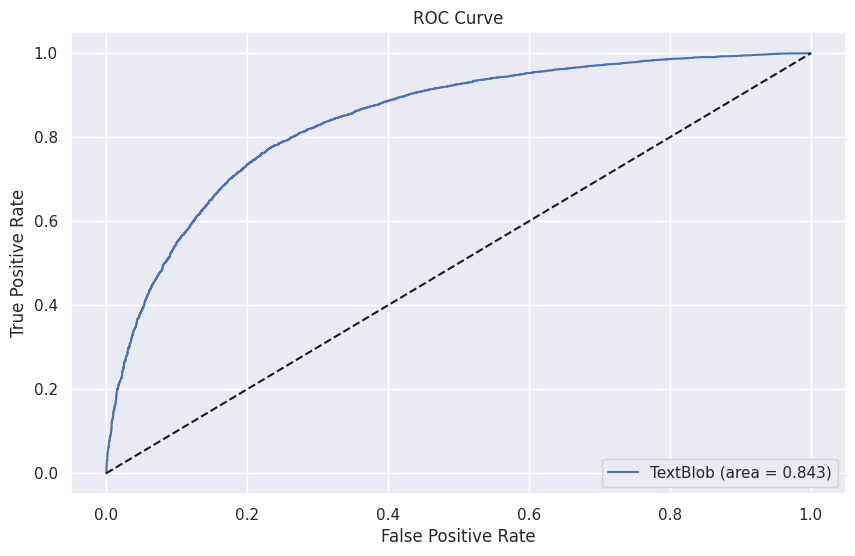

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#평가 척도 계산
cm = confusion_matrix(actual_sentiments, predicted_sentiments)
f1 = f1_score(actual_sentiments, predicted_sentiments)
precision = precision_score(actual_sentiments, predicted_sentiments)
recall = recall_score(actual_sentiments, predicted_sentiments)

#시각화
fig, axes = plt.subplots(figsize=(16, 6))

#시각화1-confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=axes)
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1:.4f} Precision: {precision:.4f} Recall: {recall:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,fontsize=12)
plt.show()

#ROC curve를 곡선으로 그리기 위해 이진값이 아닌 확률 사용
#확률 반환하는 함수
def textblob_polarity_to_prob(polarity):
    return 1 / (1 + np.exp(-polarity))

predicted_probabilities = [textblob_polarity_to_prob(TextBlob(review).sentiment.polarity) for review in df['review']]

#시각화2-ROC curve
fp, tp,_ = roc_curve(actual_sentiments, predicted_probabilities)#roc curve를 계산
auroc_baseline = roc_auc_score(actual_sentiments, predicted_probabilities)#auroc를 계산
plt.figure(figsize=(10, 6))
plt.plot(fp, tp, label=f'TextBlob (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()